In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from toolkit import MyNeuralNetwork, lossVsEpochPlot, accVsEpochPlot

In [49]:
trainData = pd.read_csv('./Data/fashion-mnist_train.csv')
testData = pd.read_csv('./Data/fashion-mnist_test.csv')

In [50]:
trainData.shape, testData.shape

((60000, 785), (10000, 785))

In [51]:
trainData = trainData.values
testData = testData.values

In [52]:
trainX = trainData[:, 1:]
trainY = trainData[:, 0]
testX = testData[:, 1:]
testY = testData[:, 0]

In [53]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [54]:
#To visualize this, I have to convert it to a 2D array of size 28 x 28
def drawImg(X, Y, i):
    plt.imshow(X[i].reshape(28, 28), cmap='gray')
    plt.title("Label " + str(Y[i]))
    plt.show()

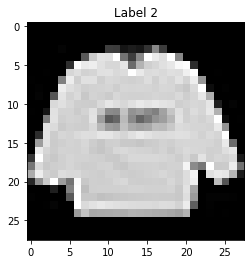

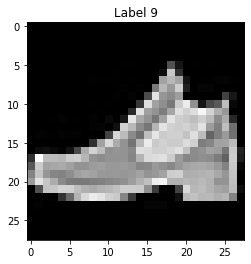

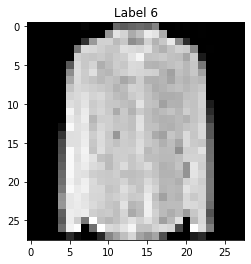

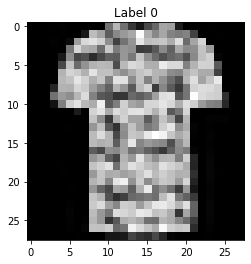

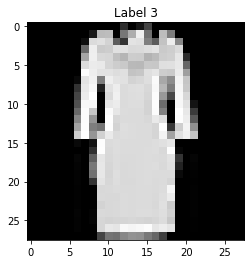

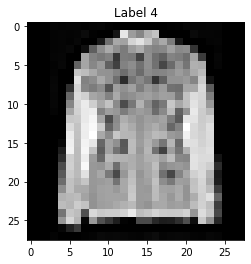

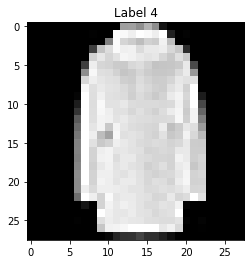

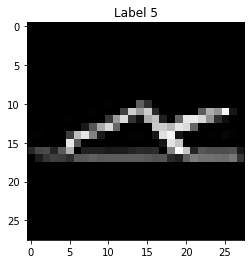

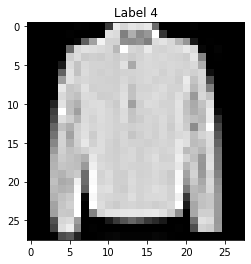

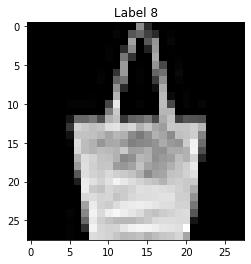

In [55]:
for i in range(10):
    drawImg(trainX, trainY, i)

In [9]:
normalize = StandardScaler()
trainX = normalize.fit_transform(trainX)
testX = normalize.transform(testX)

# Basic MLP

### ReLU

Epoch: 0, Loss: 0.23024623815976128, Score: 11.121666666666668
Epoch: 1, Loss: 0.23023747663151914, Score: 12.498333333333333
Epoch: 2, Loss: 0.23022869007363153, Score: 13.851666666666668
Epoch: 3, Loss: 0.23021985297062295, Score: 15.401666666666666
Epoch: 4, Loss: 0.23021094426263264, Score: 16.993333333333332
Epoch: 5, Loss: 0.23020193620931328, Score: 18.88
Epoch: 6, Loss: 0.23019280124785674, Score: 20.755000000000003
Epoch: 7, Loss: 0.2301835142721492, Score: 22.776666666666667
Epoch: 8, Loss: 0.23017405295765087, Score: 24.956666666666667
Epoch: 9, Loss: 0.23016438946611326, Score: 27.310000000000002
Epoch: 10, Loss: 0.2301544913604394, Score: 29.456666666666663
Epoch: 11, Loss: 0.2301443346161631, Score: 31.540000000000003
Epoch: 12, Loss: 0.23013388927907436, Score: 33.67666666666666
Epoch: 13, Loss: 0.23012312137444887, Score: 35.60166666666667
Epoch: 14, Loss: 0.23011199851359643, Score: 37.57666666666667
Epoch: 15, Loss: 0.23010048479068296, Score: 39.605000000000004
Epoch

Epoch: 135, Loss: 0.10397309156650651, Score: 56.76833333333333
Epoch: 136, Loss: 0.10320687928720705, Score: 57.16
Epoch: 137, Loss: 0.10245634488422749, Score: 57.57666666666667
Epoch: 138, Loss: 0.10172049757768006, Score: 58.055
Epoch: 139, Loss: 0.10099829318002947, Score: 58.556666666666665
Epoch: 140, Loss: 0.1002885756526797, Score: 59.02666666666667
Epoch: 141, Loss: 0.09959039297146405, Score: 59.55666666666667
Epoch: 142, Loss: 0.09890306287500858, Score: 60.068333333333335
Epoch: 143, Loss: 0.09822586296746791, Score: 60.55500000000001
Epoch: 144, Loss: 0.0975581446271045, Score: 61.071666666666665
Epoch: 145, Loss: 0.09689950636289757, Score: 61.55833333333334
Epoch: 146, Loss: 0.09624935252842602, Score: 62.025
Epoch: 147, Loss: 0.09560710785037797, Score: 62.52333333333333
Epoch: 148, Loss: 0.09497242602024376, Score: 62.96166666666667
Epoch: 149, Loss: 0.09434482308525459, Score: 63.415


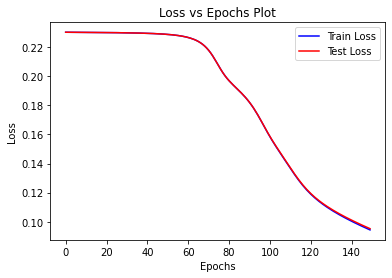

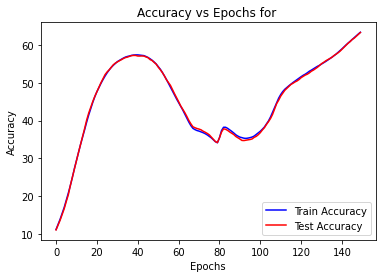

Test Accuracy: 63.349999999999994


In [12]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=2, 
                        Layer_sizes=[200, 50], activation="relu", 
                        learning_rate=0.1, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp2LayerLr0.1Relu", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.2302541225882751, Score: 10.016666666666667
Epoch: 1, Loss: 0.23025324633424069, Score: 10.15
Epoch: 2, Loss: 0.2302523701005966, Score: 10.265
Epoch: 3, Loss: 0.23025149385704077, Score: 10.381666666666668
Epoch: 4, Loss: 0.23025061757434204, Score: 10.489999999999998
Epoch: 5, Loss: 0.2302497412833351, Score: 10.621666666666666
Epoch: 6, Loss: 0.23024886485622792, Score: 10.736666666666666
Epoch: 7, Loss: 0.23024798843113706, Score: 10.868333333333334
Epoch: 8, Loss: 0.23024711183643454, Score: 10.991666666666667
Epoch: 9, Loss: 0.23024623519105875, Score: 11.118333333333332
Epoch: 10, Loss: 0.2302453584506842, Score: 11.253333333333334
Epoch: 11, Loss: 0.23024448153133212, Score: 11.401666666666667
Epoch: 12, Loss: 0.23024360460054422, Score: 11.533333333333333
Epoch: 13, Loss: 0.23024272748799998, Score: 11.666666666666666
Epoch: 14, Loss: 0.2302418502275954, Score: 11.796666666666667
Epoch: 15, Loss: 0.23024097278347117, Score: 11.943333333333333
Epoch: 16, Loss:

Epoch: 136, Loss: 0.23012515124086474, Score: 35.089999999999996
Epoch: 137, Loss: 0.23012404575316284, Score: 35.288333333333334
Epoch: 138, Loss: 0.23012293664346162, Score: 35.483333333333334
Epoch: 139, Loss: 0.23012182376286286, Score: 35.685
Epoch: 140, Loss: 0.2301207071166535, Score: 35.88333333333333
Epoch: 141, Loss: 0.2301195866388214, Score: 36.09
Epoch: 142, Loss: 0.23011846233284203, Score: 36.30166666666666
Epoch: 143, Loss: 0.23011733416901145, Score: 36.47833333333333
Epoch: 144, Loss: 0.2301162021643325, Score: 36.693333333333335
Epoch: 145, Loss: 0.23011506624398903, Score: 36.861666666666665
Epoch: 146, Loss: 0.23011392632346173, Score: 37.05833333333333
Epoch: 147, Loss: 0.23011278235228377, Score: 37.26166666666666
Epoch: 148, Loss: 0.23011163431632264, Score: 37.47333333333333
Epoch: 149, Loss: 0.23011048215834254, Score: 37.675


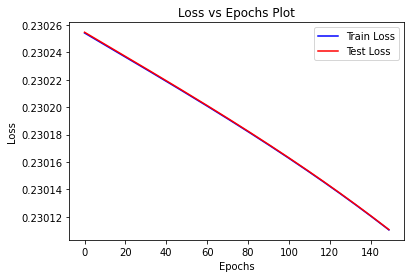

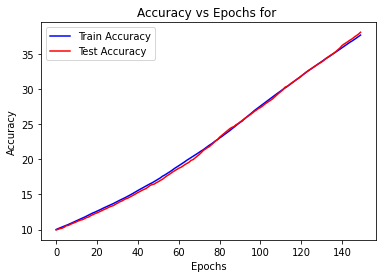

Test Accuracy: 38.080000000000005


In [13]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=2, 
                        Layer_sizes=[200, 50], activation="relu", 
                        learning_rate=0.01, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp2LayerLr0.01Relu", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.23025491120905062, Score: 9.933333333333334
Epoch: 1, Loss: 0.23025482358117205, Score: 9.945
Epoch: 2, Loss: 0.23025473595297463, Score: 9.951666666666666
Epoch: 3, Loss: 0.23025464832865628, Score: 9.961666666666668
Epoch: 4, Loss: 0.2302545607058369, Score: 9.971666666666666
Epoch: 5, Loss: 0.23025447308129413, Score: 9.978333333333333
Epoch: 6, Loss: 0.2302543854576858, Score: 9.988333333333333
Epoch: 7, Loss: 0.2302542978376425, Score: 9.998333333333333
Epoch: 8, Loss: 0.2302542102193113, Score: 10.006666666666666
Epoch: 9, Loss: 0.23025412259896474, Score: 10.016666666666667
Epoch: 10, Loss: 0.2302540349731849, Score: 10.025
Epoch: 11, Loss: 0.2302539473483779, Score: 10.043333333333333
Epoch: 12, Loss: 0.23025385972321868, Score: 10.055
Epoch: 13, Loss: 0.23025377209554537, Score: 10.061666666666666
Epoch: 14, Loss: 0.2302536844678272, Score: 10.071666666666665
Epoch: 15, Loss: 0.2302535968395699, Score: 10.083333333333332
Epoch: 16, Loss: 0.2302535092094945, S

Epoch: 136, Loss: 0.23024298974710336, Score: 11.626666666666667
Epoch: 137, Loss: 0.23024290201431544, Score: 11.635
Epoch: 138, Loss: 0.23024281428027485, Score: 11.653333333333334
Epoch: 139, Loss: 0.23024272654691702, Score: 11.666666666666666
Epoch: 140, Loss: 0.23024263881363002, Score: 11.686666666666666
Epoch: 141, Loss: 0.2302425510777191, Score: 11.696666666666665
Epoch: 142, Loss: 0.23024246334049175, Score: 11.706666666666667
Epoch: 143, Loss: 0.23024237560387467, Score: 11.721666666666666
Epoch: 144, Loss: 0.23024228786914178, Score: 11.741666666666667
Epoch: 145, Loss: 0.23024220013008007, Score: 11.756666666666666
Epoch: 146, Loss: 0.23024211238746448, Score: 11.77
Epoch: 147, Loss: 0.23024202464451562, Score: 11.773333333333333
Epoch: 148, Loss: 0.23024193690126518, Score: 11.786666666666665
Epoch: 149, Loss: 0.23024184915779333, Score: 11.795


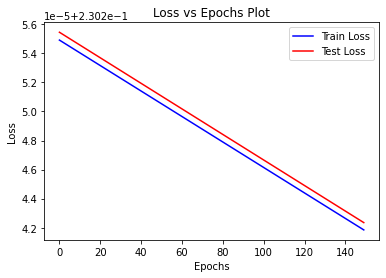

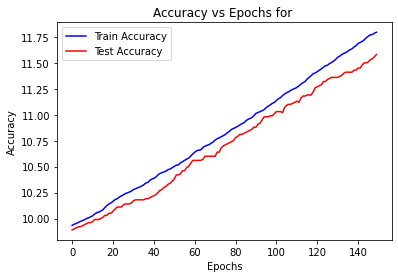

Test Accuracy: 11.58


In [14]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=2, 
                        Layer_sizes=[200, 50], activation="relu", 
                        learning_rate=0.001, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp2LayerLr0.001Relu", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.2290780222046239, Score: 26.083333333333332
Epoch: 1, Loss: 0.22763887303785202, Score: 43.001666666666665
Epoch: 2, Loss: 0.22601982480389735, Score: 47.49
Epoch: 3, Loss: 0.2240701231625729, Score: 49.91833333333333
Epoch: 4, Loss: 0.22162489624742068, Score: 51.64666666666666
Epoch: 5, Loss: 0.21849741264940215, Score: 52.65
Epoch: 6, Loss: 0.21448654501218764, Score: 53.126666666666665
Epoch: 7, Loss: 0.20940418613789016, Score: 53.08833333333334
Epoch: 8, Loss: 0.203129121786182, Score: 52.56666666666666
Epoch: 9, Loss: 0.1956850952154446, Score: 51.92333333333333
Epoch: 10, Loss: 0.1872976928400538, Score: 51.405
Epoch: 11, Loss: 0.17836463453627732, Score: 51.20666666666666
Epoch: 12, Loss: 0.1693381055574851, Score: 51.48166666666667
Epoch: 13, Loss: 0.16061561276105274, Score: 52.29333333333334
Epoch: 14, Loss: 0.152478898350825, Score: 53.349999999999994
Epoch: 15, Loss: 0.14506048447724856, Score: 54.815000000000005
Epoch: 16, Loss: 0.13837429219701064, Sco

Epoch: 135, Loss: 0.05008925285468735, Score: 82.01333333333334
Epoch: 136, Loss: 0.049980839346814424, Score: 82.05666666666667
Epoch: 137, Loss: 0.04987376994985427, Score: 82.1
Epoch: 138, Loss: 0.049767969108801526, Score: 82.135
Epoch: 139, Loss: 0.04966347053765135, Score: 82.17166666666667
Epoch: 140, Loss: 0.049560264347247356, Score: 82.245
Epoch: 141, Loss: 0.04945832869405781, Score: 82.29333333333332
Epoch: 142, Loss: 0.049357609444199146, Score: 82.32166666666667
Epoch: 143, Loss: 0.0492580625217108, Score: 82.38166666666666
Epoch: 144, Loss: 0.049159702323393, Score: 82.41666666666667
Epoch: 145, Loss: 0.049062508888589325, Score: 82.485
Epoch: 146, Loss: 0.048966465623630634, Score: 82.53
Epoch: 147, Loss: 0.048871520280430944, Score: 82.56
Epoch: 148, Loss: 0.04877769342197773, Score: 82.59
Epoch: 149, Loss: 0.048684982855378575, Score: 82.62166666666667


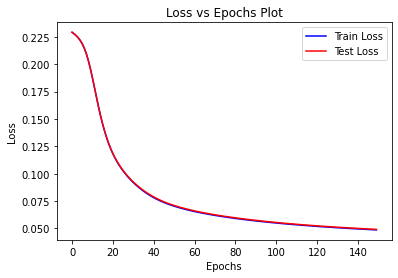

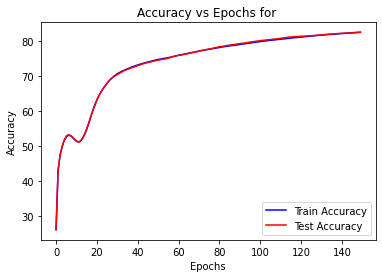

Test Accuracy: 82.59


In [15]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[100], activation="relu", 
                        learning_rate=0.1, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp1LayerLr0.1Relu", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.2303452839848501, Score: 11.291666666666666
Epoch: 1, Loss: 0.23020354284308578, Score: 12.476666666666667
Epoch: 2, Loss: 0.23006203173039388, Score: 13.676666666666668
Epoch: 3, Loss: 0.2299205905135217, Score: 15.011666666666667
Epoch: 4, Loss: 0.22977903951576498, Score: 16.411666666666665
Epoch: 5, Loss: 0.22963720828657969, Score: 17.938333333333333
Epoch: 6, Loss: 0.2294949509668111, Score: 19.638333333333332
Epoch: 7, Loss: 0.2293521339546098, Score: 21.528333333333332
Epoch: 8, Loss: 0.22920858607604813, Score: 23.64
Epoch: 9, Loss: 0.22906414600676397, Score: 26.061666666666667
Epoch: 10, Loss: 0.22891867311955377, Score: 28.595
Epoch: 11, Loss: 0.22877201976118086, Score: 31.138333333333335
Epoch: 12, Loss: 0.22862402356930944, Score: 33.44166666666666
Epoch: 13, Loss: 0.22847451222369244, Score: 35.61
Epoch: 14, Loss: 0.22832334813796182, Score: 37.388333333333335
Epoch: 15, Loss: 0.22817039410260104, Score: 38.94166666666667
Epoch: 16, Loss: 0.22801546238

Epoch: 135, Loss: 0.15832687630700432, Score: 52.76333333333333
Epoch: 136, Loss: 0.15750270576449407, Score: 52.881666666666675
Epoch: 137, Loss: 0.15668546182298587, Score: 53.00166666666667
Epoch: 138, Loss: 0.15587524730266905, Score: 53.126666666666665
Epoch: 139, Loss: 0.15507215922824322, Score: 53.266666666666666
Epoch: 140, Loss: 0.1542762757163126, Score: 53.400000000000006
Epoch: 141, Loss: 0.15348765494775068, Score: 53.54
Epoch: 142, Loss: 0.15270634353980136, Score: 53.64833333333333
Epoch: 143, Loss: 0.15193241904088733, Score: 53.75666666666666
Epoch: 144, Loss: 0.15116590579408232, Score: 53.87833333333333
Epoch: 145, Loss: 0.1504068185312634, Score: 54.03
Epoch: 146, Loss: 0.149655181770598, Score: 54.190000000000005
Epoch: 147, Loss: 0.14891100136519259, Score: 54.35
Epoch: 148, Loss: 0.1481742825827197, Score: 54.510000000000005
Epoch: 149, Loss: 0.14744501882135613, Score: 54.67833333333333


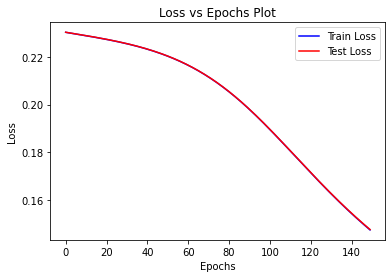

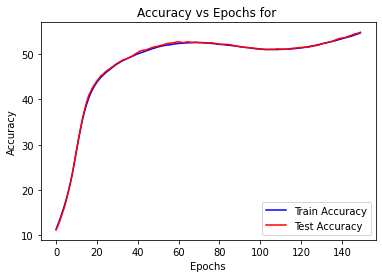

Test Accuracy: 54.83


In [16]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[100], activation="relu", 
                        learning_rate=0.01, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp1LayerLr0.01Relu", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.23047316164633141, Score: 10.403333333333334
Epoch: 1, Loss: 0.23045894703897105, Score: 10.508333333333333
Epoch: 2, Loss: 0.2304447362720483, Score: 10.615
Epoch: 3, Loss: 0.23043052927313348, Score: 10.715
Epoch: 4, Loss: 0.23041632522723454, Score: 10.796666666666667
Epoch: 5, Loss: 0.23040212466544827, Score: 10.891666666666666
Epoch: 6, Loss: 0.2303879272285731, Score: 11.011666666666667
Epoch: 7, Loss: 0.23037373306209075, Score: 11.125
Epoch: 8, Loss: 0.23035954168225337, Score: 11.213333333333333
Epoch: 9, Loss: 0.23034535331658335, Score: 11.291666666666666
Epoch: 10, Loss: 0.23033116721727362, Score: 11.4
Epoch: 11, Loss: 0.2303169835679317, Score: 11.496666666666666
Epoch: 12, Loss: 0.23030280384063226, Score: 11.633333333333333
Epoch: 13, Loss: 0.23028862717097728, Score: 11.715
Epoch: 14, Loss: 0.2302744526458921, Score: 11.833333333333334
Epoch: 15, Loss: 0.23026028109352448, Score: 11.958333333333334
Epoch: 16, Loss: 0.2302461121560477, Score: 12.10666

Epoch: 136, Loss: 0.22851398915045928, Score: 35.01166666666667
Epoch: 137, Loss: 0.22849890476860635, Score: 35.22666666666667
Epoch: 138, Loss: 0.228483803237424, Score: 35.45666666666666
Epoch: 139, Loss: 0.2284686847924881, Score: 35.623333333333335
Epoch: 140, Loss: 0.22845354909438673, Score: 35.81333333333333
Epoch: 141, Loss: 0.22843839590799592, Score: 36.02666666666667
Epoch: 142, Loss: 0.22842322534486012, Score: 36.21666666666667
Epoch: 143, Loss: 0.22840803767366932, Score: 36.415
Epoch: 144, Loss: 0.22839283228371884, Score: 36.583333333333336
Epoch: 145, Loss: 0.22837760816330735, Score: 36.76
Epoch: 146, Loss: 0.22836236488639866, Score: 36.94833333333333
Epoch: 147, Loss: 0.22834710345047313, Score: 37.108333333333334
Epoch: 148, Loss: 0.2283318242240934, Score: 37.26833333333333
Epoch: 149, Loss: 0.2283165273964324, Score: 37.41166666666666


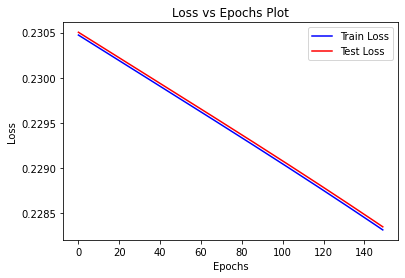

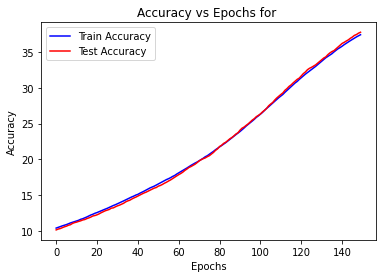

Test Accuracy: 37.76


In [17]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[100], activation="relu", 
                        learning_rate=0.001, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp1LayerLr0.001Relu", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.22700490616779206, Score: 42.04333333333333
Epoch: 1, Loss: 0.22312383909580366, Score: 53.98833333333334
Epoch: 2, Loss: 0.21884363876322177, Score: 58.74
Epoch: 3, Loss: 0.21384712632408343, Score: 62.12
Epoch: 4, Loss: 0.20785742314252237, Score: 63.245
Epoch: 5, Loss: 0.2006720837865424, Score: 63.305
Epoch: 6, Loss: 0.1922412764936238, Score: 62.839999999999996
Epoch: 7, Loss: 0.18275618451750955, Score: 62.029999999999994
Epoch: 8, Loss: 0.17267372273749926, Score: 61.108333333333334
Epoch: 9, Loss: 0.16259382054419705, Score: 60.306666666666665
Epoch: 10, Loss: 0.1530562757693673, Score: 60.02166666666666
Epoch: 11, Loss: 0.14441135184339052, Score: 60.27666666666667
Epoch: 12, Loss: 0.13680530150037837, Score: 60.858333333333334
Epoch: 13, Loss: 0.13021370340749702, Score: 61.68666666666667
Epoch: 14, Loss: 0.12450911923890322, Score: 62.71333333333333
Epoch: 15, Loss: 0.11954030093476496, Score: 63.86833333333334
Epoch: 16, Loss: 0.11517574552731584, Score: 6

Epoch: 136, Loss: 0.048738910601803874, Score: 82.675
Epoch: 137, Loss: 0.048641499543436884, Score: 82.71
Epoch: 138, Loss: 0.04854527130285733, Score: 82.74666666666667
Epoch: 139, Loss: 0.04845023929308143, Score: 82.785
Epoch: 140, Loss: 0.04835637599924194, Score: 82.83666666666667
Epoch: 141, Loss: 0.04826364032951228, Score: 82.86333333333333
Epoch: 142, Loss: 0.04817201953121315, Score: 82.91333333333334
Epoch: 143, Loss: 0.04808147584935338, Score: 82.93666666666667
Epoch: 144, Loss: 0.047991977218482834, Score: 82.98
Epoch: 145, Loss: 0.047903525101911246, Score: 83.01166666666666
Epoch: 146, Loss: 0.04781607040834961, Score: 83.05833333333334
Epoch: 147, Loss: 0.04772963235511955, Score: 83.07333333333334
Epoch: 148, Loss: 0.04764415878835933, Score: 83.12833333333333
Epoch: 149, Loss: 0.04755960845987345, Score: 83.15166666666667


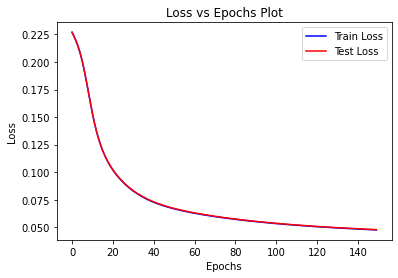

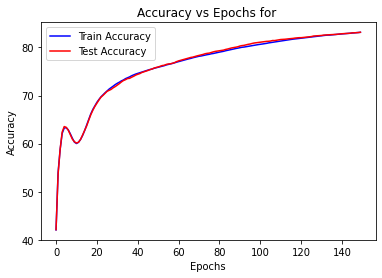

Test Accuracy: 83.17


In [31]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[256], activation="relu", 
                        learning_rate=0.1, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp1Layer256Lr0.1relu", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.23046720203011883, Score: 9.836666666666668
Epoch: 1, Loss: 0.23007917686489557, Score: 13.316666666666666
Epoch: 2, Loss: 0.22969211467501602, Score: 17.271666666666665
Epoch: 3, Loss: 0.22930558482041946, Score: 21.35333333333333
Epoch: 4, Loss: 0.2289191526629666, Score: 25.595000000000002
Epoch: 5, Loss: 0.22853241078462316, Score: 29.675
Epoch: 6, Loss: 0.22814493868890845, Score: 33.276666666666664
Epoch: 7, Loss: 0.22775629365565725, Score: 36.65333333333333
Epoch: 8, Loss: 0.22736618662663022, Score: 39.565
Epoch: 9, Loss: 0.22697427740643897, Score: 42.14333333333333
Epoch: 10, Loss: 0.22658015450425442, Score: 44.14333333333333
Epoch: 11, Loss: 0.2261833848210999, Score: 45.88333333333333
Epoch: 12, Loss: 0.22578363219358424, Score: 47.376666666666665
Epoch: 13, Loss: 0.22538057033670808, Score: 48.72166666666667
Epoch: 14, Loss: 0.22497383435200743, Score: 49.85
Epoch: 15, Loss: 0.2245630434134179, Score: 50.77666666666667
Epoch: 16, Loss: 0.224147787485474

Epoch: 135, Loss: 0.1302287965084329, Score: 61.98833333333334
Epoch: 136, Loss: 0.12962819510375542, Score: 62.085
Epoch: 137, Loss: 0.12903589089208514, Score: 62.221666666666664
Epoch: 138, Loss: 0.12845172864661566, Score: 62.32666666666666
Epoch: 139, Loss: 0.12787557456583015, Score: 62.41833333333333
Epoch: 140, Loss: 0.12730728754023357, Score: 62.513333333333335
Epoch: 141, Loss: 0.12674672885384422, Score: 62.61333333333333
Epoch: 142, Loss: 0.126193752665428, Score: 62.72833333333333
Epoch: 143, Loss: 0.12564822706381845, Score: 62.83833333333333
Epoch: 144, Loss: 0.12511000766463112, Score: 62.96000000000001
Epoch: 145, Loss: 0.12457896343084054, Score: 63.07000000000001
Epoch: 146, Loss: 0.12405495161635491, Score: 63.154999999999994
Epoch: 147, Loss: 0.12353784209701864, Score: 63.24999999999999
Epoch: 148, Loss: 0.12302752607515337, Score: 63.36166666666667
Epoch: 149, Loss: 0.12252386375133474, Score: 63.480000000000004


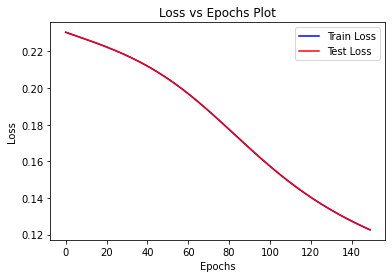

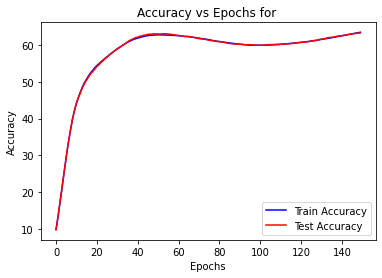

Test Accuracy: 63.3


In [32]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[256], activation="relu", 
                        learning_rate=0.01, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp1Layer256Lr0.01relu", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.23081763649614145, Score: 6.913333333333334
Epoch: 1, Loss: 0.23077867580652892, Score: 7.216666666666667
Epoch: 2, Loss: 0.2307397284362595, Score: 7.533333333333333
Epoch: 3, Loss: 0.2307007948854796, Score: 7.863333333333333
Epoch: 4, Loss: 0.23066187466767762, Score: 8.146666666666667
Epoch: 5, Loss: 0.23062296692790454, Score: 8.481666666666667
Epoch: 6, Loss: 0.23058407287395177, Score: 8.81
Epoch: 7, Loss: 0.2305451925197187, Score: 9.116666666666665
Epoch: 8, Loss: 0.23050632736467883, Score: 9.456666666666665
Epoch: 9, Loss: 0.23046747438923407, Score: 9.836666666666668
Epoch: 10, Loss: 0.23042863306447442, Score: 10.156666666666666
Epoch: 11, Loss: 0.23038980372604792, Score: 10.48
Epoch: 12, Loss: 0.23035098630896653, Score: 10.79
Epoch: 13, Loss: 0.2303121798804849, Score: 11.141666666666666
Epoch: 14, Loss: 0.23027338356754729, Score: 11.491666666666667
Epoch: 15, Loss: 0.23023459665850543, Score: 11.875
Epoch: 16, Loss: 0.230195817216073, Score: 12.25
Ep

Epoch: 136, Loss: 0.22548819278844398, Score: 48.388333333333335
Epoch: 137, Loss: 0.22544756735789284, Score: 48.513333333333335
Epoch: 138, Loss: 0.22540690389187149, Score: 48.63166666666667
Epoch: 139, Loss: 0.22536620100027877, Score: 48.733333333333334
Epoch: 140, Loss: 0.22532545975219304, Score: 48.84166666666667
Epoch: 141, Loss: 0.22528467966159335, Score: 48.980000000000004
Epoch: 142, Loss: 0.22524386073193822, Score: 49.11333333333333
Epoch: 143, Loss: 0.22520300166548204, Score: 49.214999999999996
Epoch: 144, Loss: 0.22516210113792995, Score: 49.32166666666667
Epoch: 145, Loss: 0.22512115931372667, Score: 49.415
Epoch: 146, Loss: 0.22508017523603563, Score: 49.545
Epoch: 147, Loss: 0.2250391505175069, Score: 49.635
Epoch: 148, Loss: 0.22499808656921266, Score: 49.75666666666667
Epoch: 149, Loss: 0.22495698103583586, Score: 49.85333333333333


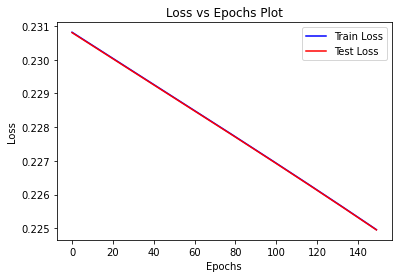

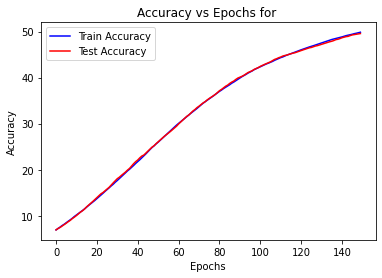

Test Accuracy: 49.57


In [33]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[256], activation="relu", 
                        learning_rate=0.001, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp1Layer256Lr0.001relu", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

### Sigmoid

Epoch: 0, Loss: 0.23028465053025812, Score: 10.0
Epoch: 1, Loss: 0.2302780367927141, Score: 10.0
Epoch: 2, Loss: 0.2302730499880329, Score: 10.0
Epoch: 3, Loss: 0.23026926983535756, Score: 10.0
Epoch: 4, Loss: 0.23026638565660007, Score: 10.0
Epoch: 5, Loss: 0.23026416741514102, Score: 10.021666666666667
Epoch: 6, Loss: 0.23026244454615716, Score: 10.411666666666667
Epoch: 7, Loss: 0.23026109043112897, Score: 10.841666666666667
Epoch: 8, Loss: 0.23026001097982463, Score: 10.091666666666667
Epoch: 9, Loss: 0.2302591362131537, Score: 9.396666666666667
Epoch: 10, Loss: 0.2302584140457146, Score: 9.5
Epoch: 11, Loss: 0.2302578056853182, Score: 9.813333333333334
Epoch: 12, Loss: 0.23025728222399397, Score: 10.035
Epoch: 13, Loss: 0.23025682210875548, Score: 10.08
Epoch: 14, Loss: 0.23025640926308905, Score: 10.046666666666667
Epoch: 15, Loss: 0.23025603169048128, Score: 10.023333333333333
Epoch: 16, Loss: 0.23025568043548011, Score: 10.013333333333334
Epoch: 17, Loss: 0.23025534881023504, S

Epoch: 135, Loss: 0.23021822099393346, Score: 19.01666666666667
Epoch: 136, Loss: 0.23021782578809366, Score: 19.163333333333334
Epoch: 137, Loss: 0.2302174283255075, Score: 19.336666666666666
Epoch: 138, Loss: 0.230217028577967, Score: 19.5
Epoch: 139, Loss: 0.2302166265169695, Score: 19.668333333333333
Epoch: 140, Loss: 0.23021622211371218, Score: 19.845
Epoch: 141, Loss: 0.23021581533908772, Score: 20.028333333333332
Epoch: 142, Loss: 0.23021540616367886, Score: 20.191666666666666
Epoch: 143, Loss: 0.23021499455775402, Score: 20.368333333333332
Epoch: 144, Loss: 0.2302145804912616, Score: 20.546666666666667
Epoch: 145, Loss: 0.23021416393382518, Score: 20.724999999999998
Epoch: 146, Loss: 0.23021374485473808, Score: 20.921666666666667
Epoch: 147, Loss: 0.23021332322295823, Score: 21.10666666666667
Epoch: 148, Loss: 0.23021289900710235, Score: 21.27
Epoch: 149, Loss: 0.2302124721754409, Score: 21.453333333333333


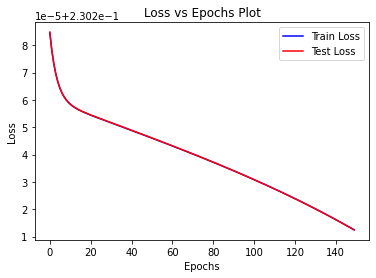

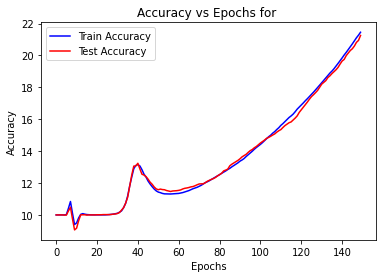

Test Accuracy: 21.25


In [18]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=2, 
                        Layer_sizes=[200, 50], activation="sigmoid", 
                        learning_rate=0.1, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp2LayerLr0.1sigmoid", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.23029252272060532, Score: 10.0
Epoch: 1, Loss: 0.23029160963422363, Score: 10.0
Epoch: 2, Loss: 0.23029072090409522, Score: 10.0
Epoch: 3, Loss: 0.23028985585286718, Score: 10.0
Epoch: 4, Loss: 0.23028901382234665, Score: 10.0
Epoch: 5, Loss: 0.23028819417294313, Score: 10.0
Epoch: 6, Loss: 0.2302873962831321, Score: 10.0
Epoch: 7, Loss: 0.23028661954893018, Score: 10.0
Epoch: 8, Loss: 0.23028586338338947, Score: 10.0
Epoch: 9, Loss: 0.23028512721610436, Score: 10.0
Epoch: 10, Loss: 0.23028441049273538, Score: 10.0
Epoch: 11, Loss: 0.2302837126745454, Score: 10.0
Epoch: 12, Loss: 0.23028303323795102, Score: 10.0
Epoch: 13, Loss: 0.23028237167408616, Score: 10.0
Epoch: 14, Loss: 0.23028172748837988, Score: 10.0
Epoch: 15, Loss: 0.2302811002001451, Score: 10.0
Epoch: 16, Loss: 0.23028048934218148, Score: 10.0
Epoch: 17, Loss: 0.23027989446038813, Score: 10.0
Epoch: 18, Loss: 0.23027931511338873, Score: 10.0
Epoch: 19, Loss: 0.23027875087216826, Score: 10.0
Epoch: 20, Lo

Epoch: 146, Loss: 0.23025666982796889, Score: 10.123333333333333
Epoch: 147, Loss: 0.23025662656752727, Score: 10.115
Epoch: 148, Loss: 0.23025658373618163, Score: 10.105
Epoch: 149, Loss: 0.23025654132231949, Score: 10.096666666666666


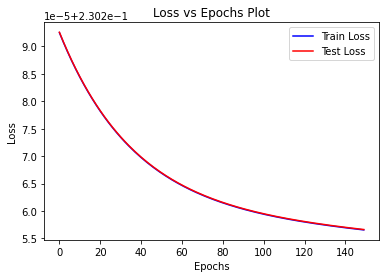

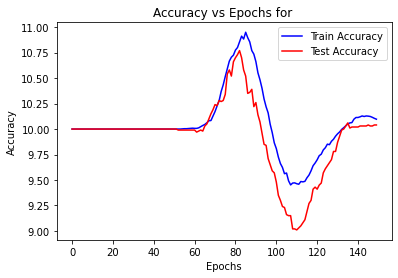

Test Accuracy: 10.040000000000001


In [19]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=2, 
                        Layer_sizes=[200, 50], activation="sigmoid", 
                        learning_rate=0.01, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp2LayerLr0.01sigmoid", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.23029336647469076, Score: 10.0
Epoch: 1, Loss: 0.2302932723427997, Score: 10.0
Epoch: 2, Loss: 0.2302931784639414, Score: 10.0
Epoch: 3, Loss: 0.23029308483740685, Score: 10.0
Epoch: 4, Loss: 0.23029299146248938, Score: 10.0
Epoch: 5, Loss: 0.23029289833848413, Score: 10.0
Epoch: 6, Loss: 0.23029280546468833, Score: 10.0
Epoch: 7, Loss: 0.23029271284040087, Score: 10.0
Epoch: 8, Loss: 0.23029262046492344, Score: 10.0
Epoch: 9, Loss: 0.2302925283375587, Score: 10.0
Epoch: 10, Loss: 0.2302924364576121, Score: 10.0
Epoch: 11, Loss: 0.23029234482439084, Score: 10.0
Epoch: 12, Loss: 0.23029225343720386, Score: 10.0
Epoch: 13, Loss: 0.2302921622953624, Score: 10.0
Epoch: 14, Loss: 0.2302920713981792, Score: 10.0
Epoch: 15, Loss: 0.23029198074496968, Score: 10.0
Epoch: 16, Loss: 0.23029189033505051, Score: 10.0
Epoch: 17, Loss: 0.23029180016774078, Score: 10.0
Epoch: 18, Loss: 0.23029171024236114, Score: 10.0
Epoch: 19, Loss: 0.23029162055823452, Score: 10.0
Epoch: 20, Loss:

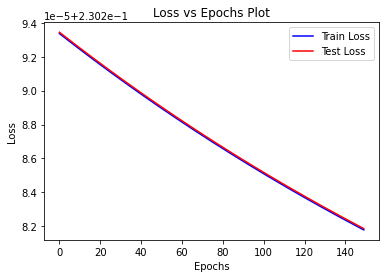

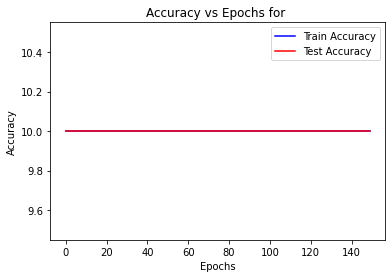

Test Accuracy: 10.0


In [20]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=2, 
                        Layer_sizes=[200, 50], activation="sigmoid", 
                        learning_rate=0.001, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp2LayerLr0.001sigmoid", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.
Epoch: 0, Loss: 0.2300312257881476, Score: 11.131666666666666
Epoch: 1, Loss: 0.2297285878408919, Score: 19.251666666666665
Epoch: 2, Loss: 0.22943001859030435, Score: 27.52
Epoch: 3, Loss: 0.2291269665195039, Score: 32.0
Epoch: 4, Loss: 0.22881258387740613, Score: 39.626666666666665
Epoch: 5, Loss: 0.22848091685170807, Score: 42.02333333333333
Epoch: 6, Loss: 0.22812642126497837, Score: 43.59166666666667
Epoch: 7, Loss: 0.22774367386245567, Score: 44.85166666666667
Epoch: 8, Loss: 0.22732720252010816, Score: 45.879999999999995
Epoch: 9, Loss: 0.2268713916798353, Score: 47.041666666666664
Epoch: 10, Loss: 0.22637043933650963, Score: 48.185
Epoch: 11, Loss: 0.22581835375788106, Score: 49.21
Epoch: 12, Loss: 0.22520898488675414, Score: 49.99
Epoch: 13, Loss: 0.22453608892861962, Score: 50.62833333333333
Epoch: 14, Loss: 0.22379342604769492, Score:

Epoch: 133, Loss: 0.097069695281125, Score: 70.08666666666666
Epoch: 134, Loss: 0.09665968912000075, Score: 70.23666666666666
Epoch: 135, Loss: 0.09625451795436984, Score: 70.36166666666666
Epoch: 136, Loss: 0.09585412225862074, Score: 70.47666666666666
Epoch: 137, Loss: 0.0954584437741955, Score: 70.6
Epoch: 138, Loss: 0.09506742544933655, Score: 70.70166666666667
Epoch: 139, Loss: 0.09468101137972205, Score: 70.79333333333334
Epoch: 140, Loss: 0.09429914675024077, Score: 70.91333333333333
Epoch: 141, Loss: 0.09392177777814033, Score: 71.045
Epoch: 142, Loss: 0.09354885165776546, Score: 71.12
Epoch: 143, Loss: 0.09318031650708246, Score: 71.19833333333332
Epoch: 144, Loss: 0.09281612131616221, Score: 71.26333333333334
Epoch: 145, Loss: 0.09245621589776948, Score: 71.35000000000001
Epoch: 146, Loss: 0.09210055084018001, Score: 71.44166666666666
Epoch: 147, Loss: 0.09174907746231963, Score: 71.51833333333333
Epoch: 148, Loss: 0.09140174777129272, Score: 71.59333333333333
Epoch: 149, Los

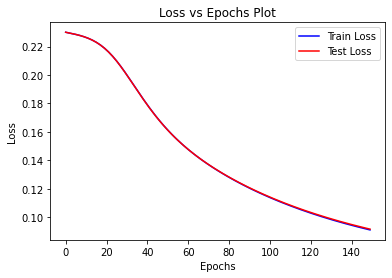

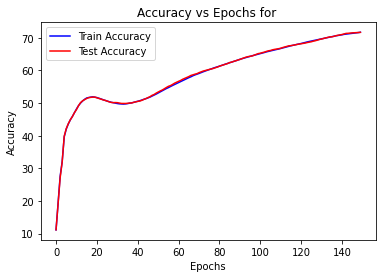

Test Accuracy: 71.66


In [21]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[100], activation="sigmoid", 
                        learning_rate=0.1, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp1LayerLr0.1sigmoid", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.2303171917076695, Score: 10.008333333333333
Epoch: 1, Loss: 0.23028506534911075, Score: 10.018333333333333
Epoch: 2, Loss: 0.2302531447584676, Score: 10.043333333333333
Epoch: 3, Loss: 0.23022141586814843, Score: 10.068333333333333
Epoch: 4, Loss: 0.23018986506422015, Score: 10.116666666666667
Epoch: 5, Loss: 0.23015847916523868, Score: 10.195
Epoch: 6, Loss: 0.23012724540198434, Score: 10.301666666666668
Epoch: 7, Loss: 0.2300961513980656, Score: 10.428333333333335
Epoch: 8, Loss: 0.23006518515135133, Score: 10.628333333333332
Epoch: 9, Loss: 0.23003433501619944, Score: 10.863333333333333
Epoch: 10, Loss: 0.2300035896864434, Score: 11.19
Epoch: 11, Loss: 0.22997293817910894, Score: 11.638333333333334
Epoch: 12, Loss: 0.22994236981882632, Score: 12.145
Epoch: 13, Loss: 0.2299118742229113, Score: 12.83
Epoch: 14, Loss: 0.22988144128708402, Score: 13.569999999999999
Epoch: 15, Loss: 0.2298510611718014, Score: 14.401666666666666
Epoch: 16, Loss: 0.22982072428917502, Scor

Epoch: 137, Loss: 0.22442002520715046, Score: 50.21666666666667
Epoch: 138, Loss: 0.22434558658239923, Score: 50.275000000000006
Epoch: 139, Loss: 0.22427039766708476, Score: 50.33833333333333
Epoch: 140, Loss: 0.22419445206358815, Score: 50.388333333333335
Epoch: 141, Loss: 0.22411774340153556, Score: 50.43333333333333
Epoch: 142, Loss: 0.22404026533968993, Score: 50.49333333333333
Epoch: 143, Loss: 0.22396201156787313, Score: 50.54333333333333
Epoch: 144, Loss: 0.22388297580892322, Score: 50.57333333333334
Epoch: 145, Loss: 0.22380315182067842, Score: 50.63333333333333
Epoch: 146, Loss: 0.22372253339799397, Score: 50.693333333333335
Epoch: 147, Loss: 0.2236411143747871, Score: 50.754999999999995
Epoch: 148, Loss: 0.22355888862611067, Score: 50.806666666666665
Epoch: 149, Loss: 0.223475850070255, Score: 50.85666666666666


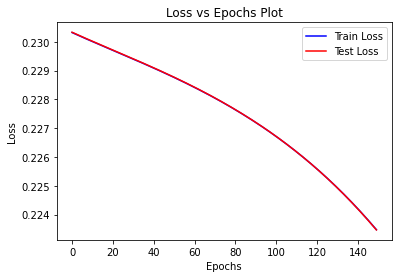

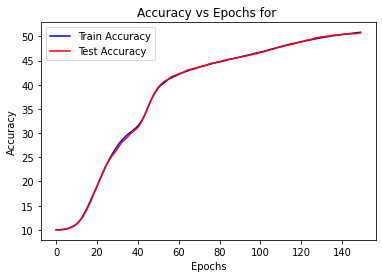

Test Accuracy: 50.739999999999995


In [22]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[100], activation="sigmoid", 
                        learning_rate=0.01, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp1LayerLr0.01sigmoid", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.2303462985854223, Score: 10.003333333333334
Epoch: 1, Loss: 0.23034306106237665, Score: 10.003333333333334
Epoch: 2, Loss: 0.23033982579350878, Score: 10.003333333333334
Epoch: 3, Loss: 0.23033659276400212, Score: 10.005
Epoch: 4, Loss: 0.2303333619590889, Score: 10.006666666666666
Epoch: 5, Loss: 0.23033013336405067, Score: 10.008333333333333
Epoch: 6, Loss: 0.23032690696421818, Score: 10.008333333333333
Epoch: 7, Loss: 0.23032368274497014, Score: 10.008333333333333
Epoch: 8, Loss: 0.23032046069173384, Score: 10.008333333333333
Epoch: 9, Loss: 0.23031724078998483, Score: 10.008333333333333
Epoch: 10, Loss: 0.23031402302524642, Score: 10.01
Epoch: 11, Loss: 0.2303108073830897, Score: 10.01
Epoch: 12, Loss: 0.23030759384913302, Score: 10.01
Epoch: 13, Loss: 0.2303043824090425, Score: 10.01
Epoch: 14, Loss: 0.23030117304853043, Score: 10.01
Epoch: 15, Loss: 0.2302979657533568, Score: 10.01
Epoch: 16, Loss: 0.2302947605093277, Score: 10.01
Epoch: 17, Loss: 0.230291557302

Epoch: 136, Loss: 0.22992120953022202, Score: 12.563333333333334
Epoch: 137, Loss: 0.22991815995061, Score: 12.64
Epoch: 138, Loss: 0.2299151109801925, Score: 12.691666666666668
Epoch: 139, Loss: 0.22991206260909602, Score: 12.770000000000001
Epoch: 140, Loss: 0.22990901482747214, Score: 12.833333333333332
Epoch: 141, Loss: 0.22990596762549836, Score: 12.891666666666667
Epoch: 142, Loss: 0.22990292099337706, Score: 12.968333333333334
Epoch: 143, Loss: 0.22989987492133607, Score: 13.053333333333333
Epoch: 144, Loss: 0.22989682939962833, Score: 13.11
Epoch: 145, Loss: 0.22989378441853123, Score: 13.183333333333334
Epoch: 146, Loss: 0.22989073996834744, Score: 13.255
Epoch: 147, Loss: 0.229887696039404, Score: 13.318333333333332
Epoch: 148, Loss: 0.22988465262205263, Score: 13.396666666666668
Epoch: 149, Loss: 0.22988160970666954, Score: 13.491666666666665


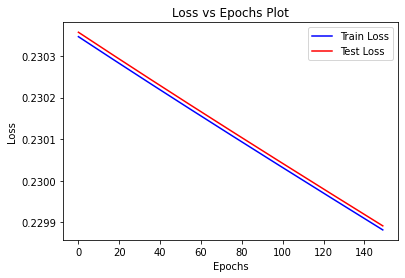

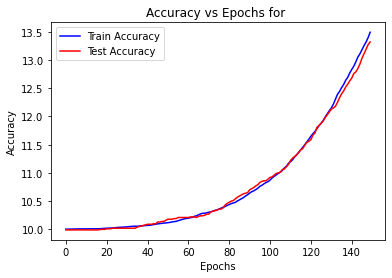

Test Accuracy: 13.320000000000002


In [23]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[100], activation="sigmoid", 
                        learning_rate=0.001, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp1LayerLr0.001sigmoid", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.22984300773721625, Score: 13.28
Epoch: 1, Loss: 0.2290884331847282, Score: 28.389999999999997
Epoch: 2, Loss: 0.22834212535829954, Score: 43.971666666666664
Epoch: 3, Loss: 0.22757768529020178, Score: 49.64
Epoch: 4, Loss: 0.22678193427101423, Score: 52.690000000000005
Epoch: 5, Loss: 0.2259434384943379, Score: 55.34833333333333
Epoch: 6, Loss: 0.2250510279906931, Score: 57.51500000000001
Epoch: 7, Loss: 0.22409360774691842, Score: 59.07333333333333
Epoch: 8, Loss: 0.22306018040988876, Score: 60.20333333333333
Epoch: 9, Loss: 0.22193995249777596, Score: 60.95666666666667
Epoch: 10, Loss: 0.22072251260911813, Score: 61.36666666666667
Epoch: 11, Loss: 0.21939808194735416, Score: 61.68666666666667
Epoch: 12, Loss: 0.21795783456367543, Score: 61.905
Epoch: 13, Loss: 0.21639427796117527, Score: 62.016666666666666
Epoch: 14, Loss: 0.21470167563364193, Score: 61.973333333333336
Epoch: 15, Loss: 0.2128764826541774, Score: 61.95166666666667
Epoch: 16, Loss: 0.21091775509406122

Epoch: 137, Loss: 0.08043139954815508, Score: 73.38666666666667
Epoch: 138, Loss: 0.08016699308347164, Score: 73.42666666666666
Epoch: 139, Loss: 0.07990683255153426, Score: 73.48
Epoch: 140, Loss: 0.0796508291420834, Score: 73.51333333333334
Epoch: 141, Loss: 0.07939889564374857, Score: 73.55000000000001
Epoch: 142, Loss: 0.07915094643428293, Score: 73.58833333333334
Epoch: 143, Loss: 0.0789068974700901, Score: 73.61833333333333
Epoch: 144, Loss: 0.07866666627504214, Score: 73.66
Epoch: 145, Loss: 0.07843017192859834, Score: 73.68666666666667
Epoch: 146, Loss: 0.0781973350532345, Score: 73.72
Epoch: 147, Loss: 0.07796807780119838, Score: 73.745
Epoch: 148, Loss: 0.07774232384061104, Score: 73.78833333333333
Epoch: 149, Loss: 0.07751999834093602, Score: 73.82166666666666


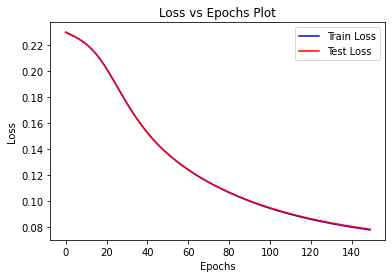

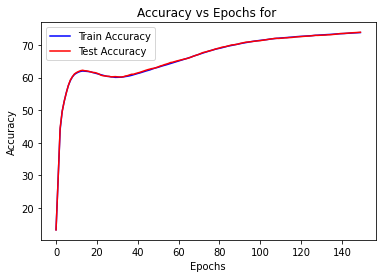

Test Accuracy: 73.92


In [34]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[256], activation="sigmoid", 
                        learning_rate=0.1, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp1Layer256Lr0.1sigmoid", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.23064054953218927, Score: 6.298333333333334
Epoch: 1, Loss: 0.23054712509123496, Score: 6.4783333333333335
Epoch: 2, Loss: 0.23045621257731963, Score: 6.831666666666666
Epoch: 3, Loss: 0.2303674938394304, Score: 7.286666666666666
Epoch: 4, Loss: 0.2302806893114386, Score: 8.006666666666666
Epoch: 5, Loss: 0.23019555310372578, Score: 9.041666666666668
Epoch: 6, Loss: 0.23011186873387346, Score: 10.285
Epoch: 7, Loss: 0.23002944540944983, Score: 11.706666666666667
Epoch: 8, Loss: 0.22994811478867777, Score: 13.291666666666666
Epoch: 9, Loss: 0.229867728155435, Score: 14.748333333333333
Epoch: 10, Loss: 0.22978815395401858, Score: 16.2
Epoch: 11, Loss: 0.22970927563668767, Score: 17.671666666666667
Epoch: 12, Loss: 0.2296309897834369, Score: 19.101666666666667
Epoch: 13, Loss: 0.22955320445893176, Score: 20.416666666666668
Epoch: 14, Loss: 0.22947583777622582, Score: 21.598333333333333
Epoch: 15, Loss: 0.22939881664089515, Score: 22.85
Epoch: 16, Loss: 0.2293220756526784

Epoch: 134, Loss: 0.21667797811051356, Score: 61.809999999999995
Epoch: 135, Loss: 0.21651256989830947, Score: 61.82
Epoch: 136, Loss: 0.2163458349017584, Score: 61.84666666666667
Epoch: 137, Loss: 0.21617776897706872, Score: 61.83
Epoch: 138, Loss: 0.21600836823235967, Score: 61.82833333333333
Epoch: 139, Loss: 0.21583762903209555, Score: 61.809999999999995
Epoch: 140, Loss: 0.21566554800146026, Score: 61.81833333333333
Epoch: 141, Loss: 0.2154921220306639, Score: 61.82333333333333
Epoch: 142, Loss: 0.21531734827917817, Score: 61.821666666666665
Epoch: 143, Loss: 0.2151412241798946, Score: 61.824999999999996
Epoch: 144, Loss: 0.2149637474431985, Score: 61.82666666666666
Epoch: 145, Loss: 0.21478491606095548, Score: 61.81666666666666
Epoch: 146, Loss: 0.21460472831040223, Score: 61.81333333333333
Epoch: 147, Loss: 0.21442318275793812, Score: 61.81333333333333
Epoch: 148, Loss: 0.2142402782628101, Score: 61.806666666666665
Epoch: 149, Loss: 0.21405601398068724, Score: 61.79666666666667


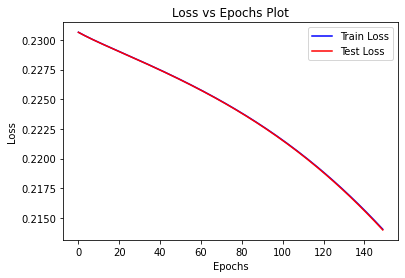

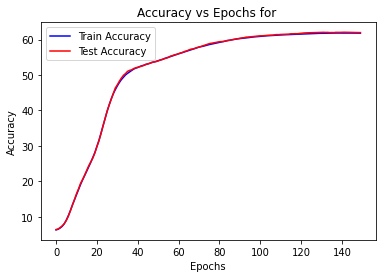

Test Accuracy: 61.95


In [35]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[256], activation="sigmoid", 
                        learning_rate=0.01, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp1Layer256Lr0.01sigmoid", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.23072714931751984, Score: 6.1866666666666665
Epoch: 1, Loss: 0.23071748085516666, Score: 6.1883333333333335
Epoch: 2, Loss: 0.23070784250337542, Score: 6.196666666666667
Epoch: 3, Loss: 0.23069823387180377, Score: 6.211666666666667
Epoch: 4, Loss: 0.23068865457504142, Score: 6.236666666666666
Epoch: 5, Loss: 0.230679104232545, Score: 6.25
Epoch: 6, Loss: 0.2306695824685736, Score: 6.271666666666667
Epoch: 7, Loss: 0.23066008891212517, Score: 6.276666666666666
Epoch: 8, Loss: 0.23065062319687363, Score: 6.291666666666666
Epoch: 9, Loss: 0.23064118496110697, Score: 6.3133333333333335
Epoch: 10, Loss: 0.23063177384766642, Score: 6.335
Epoch: 11, Loss: 0.23062238950388614, Score: 6.356666666666666
Epoch: 12, Loss: 0.23061303158153376, Score: 6.366666666666666
Epoch: 13, Loss: 0.23060369973675238, Score: 6.38
Epoch: 14, Loss: 0.23059439363000167, Score: 6.408333333333334
Epoch: 15, Loss: 0.23058511292600214, Score: 6.433333333333334
Epoch: 16, Loss: 0.2305758572936782, Sco

Epoch: 140, Loss: 0.22954674698130426, Score: 20.516666666666666
Epoch: 141, Loss: 0.2295389817913983, Score: 20.641666666666666
Epoch: 142, Loss: 0.22953122055529598, Score: 20.766666666666666
Epoch: 143, Loss: 0.22952346320004313, Score: 20.893333333333334
Epoch: 144, Loss: 0.22951570965347706, Score: 21.005
Epoch: 145, Loss: 0.22950795984421488, Score: 21.111666666666668
Epoch: 146, Loss: 0.2295002137016439, Score: 21.245
Epoch: 147, Loss: 0.22949247115591162, Score: 21.361666666666668
Epoch: 148, Loss: 0.22948473213791706, Score: 21.465
Epoch: 149, Loss: 0.22947699657929987, Score: 21.578333333333333


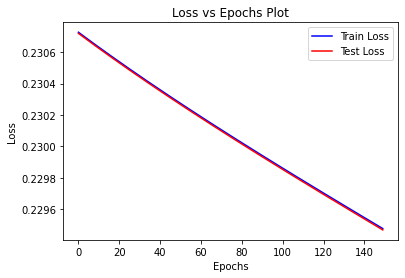

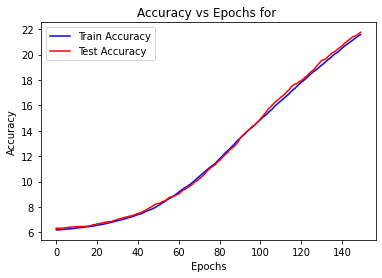

Test Accuracy: 21.759999999999998


In [36]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[256], activation="sigmoid", 
                        learning_rate=0.001, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp1Layer256Lr0.001sigmoid", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

### Tanh

Epoch: 0, Loss: 0.23021518875803273, Score: 12.058333333333334
Epoch: 1, Loss: 0.2301513095311284, Score: 15.395
Epoch: 2, Loss: 0.2300868730291781, Score: 19.09166666666667
Epoch: 3, Loss: 0.2300211297293912, Score: 23.618333333333332
Epoch: 4, Loss: 0.2299533114603175, Score: 29.441666666666666
Epoch: 5, Loss: 0.2298826135644745, Score: 36.0
Epoch: 6, Loss: 0.22980817593811576, Score: 41.47833333333333
Epoch: 7, Loss: 0.22972906215827302, Score: 45.53666666666666
Epoch: 8, Loss: 0.22964423581183133, Score: 48.431666666666665
Epoch: 9, Loss: 0.22955253299229486, Score: 50.623333333333335
Epoch: 10, Loss: 0.22945262971851466, Score: 52.39
Epoch: 11, Loss: 0.22934300274364824, Score: 53.55166666666666
Epoch: 12, Loss: 0.2292218818458472, Score: 54.498333333333335
Epoch: 13, Loss: 0.22908719120488202, Score: 55.126666666666665
Epoch: 14, Loss: 0.22893647684913226, Score: 55.565
Epoch: 15, Loss: 0.22876681638396548, Score: 55.81666666666667
Epoch: 16, Loss: 0.2285747062726595, Score: 55.9

Epoch: 135, Loss: 0.0919829550998484, Score: 68.28833333333333
Epoch: 136, Loss: 0.0915504276077645, Score: 68.43166666666667
Epoch: 137, Loss: 0.09112036797745823, Score: 68.58833333333332
Epoch: 138, Loss: 0.09069284063975003, Score: 68.72333333333333
Epoch: 139, Loss: 0.09026791889500246, Score: 68.925
Epoch: 140, Loss: 0.08984568407896286, Score: 69.10833333333333
Epoch: 141, Loss: 0.08942622456851365, Score: 69.28666666666666
Epoch: 142, Loss: 0.08900963464030719, Score: 69.455
Epoch: 143, Loss: 0.08859601320217994, Score: 69.59833333333333
Epoch: 144, Loss: 0.08818546242345898, Score: 69.77333333333333
Epoch: 145, Loss: 0.0877780862953844, Score: 69.92166666666667
Epoch: 146, Loss: 0.08737398915654267, Score: 70.1
Epoch: 147, Loss: 0.08697327422020332, Score: 70.26166666666667
Epoch: 148, Loss: 0.08657604214065476, Score: 70.415
Epoch: 149, Loss: 0.08618238965406347, Score: 70.58833333333332


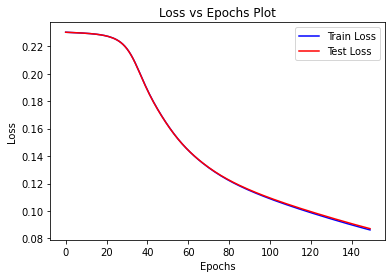

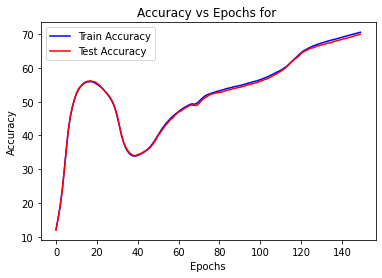

Test Accuracy: 69.99


In [24]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=2, 
                        Layer_sizes=[200, 50], activation="tanh", 
                        learning_rate=0.1, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp2LayerLr0.1tanh", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.23027283920294567, Score: 9.185
Epoch: 1, Loss: 0.2302664246575157, Score: 9.508333333333335
Epoch: 2, Loss: 0.23026001464831866, Score: 9.826666666666666
Epoch: 3, Loss: 0.23025360841969755, Score: 10.146666666666667
Epoch: 4, Loss: 0.2302472052174566, Score: 10.453333333333333
Epoch: 5, Loss: 0.230240804288682, Score: 10.753333333333332
Epoch: 6, Loss: 0.23023440488156235, Score: 11.07
Epoch: 7, Loss: 0.23022800624521178, Score: 11.42
Epoch: 8, Loss: 0.23022160762949104, Score: 11.74
Epoch: 9, Loss: 0.23021520828483205, Score: 12.051666666666666
Epoch: 10, Loss: 0.2302088074620608, Score: 12.376666666666667
Epoch: 11, Loss: 0.23020240441222137, Score: 12.695
Epoch: 12, Loss: 0.2301959983864008, Score: 13.05
Epoch: 13, Loss: 0.23018958863555322, Score: 13.371666666666668
Epoch: 14, Loss: 0.23018317441032476, Score: 13.736666666666666
Epoch: 15, Loss: 0.23017675496087867, Score: 14.063333333333333
Epoch: 16, Loss: 0.23017032953671965, Score: 14.393333333333333
Epoch: 

Epoch: 135, Loss: 0.22909687279032528, Score: 54.765
Epoch: 136, Loss: 0.22908210455254685, Score: 54.81166666666667
Epoch: 137, Loss: 0.2290671608534282, Score: 54.855
Epoch: 138, Loss: 0.22905203860633536, Score: 54.913333333333334
Epoch: 139, Loss: 0.22903673466649274, Score: 54.95833333333333
Epoch: 140, Loss: 0.22902124582965447, Score: 55.01166666666667
Epoch: 141, Loss: 0.22900556883074216, Score: 55.04666666666667
Epoch: 142, Loss: 0.2289897003424517, Score: 55.06833333333333
Epoch: 143, Loss: 0.22897363697382603, Score: 55.125
Epoch: 144, Loss: 0.22895737526879395, Score: 55.175
Epoch: 145, Loss: 0.22894091170467287, Score: 55.22
Epoch: 146, Loss: 0.228924242690637, Score: 55.24333333333333
Epoch: 147, Loss: 0.2289073645661475, Score: 55.266666666666666
Epoch: 148, Loss: 0.22889027359934602, Score: 55.315000000000005
Epoch: 149, Loss: 0.22887296598540804, Score: 55.364999999999995


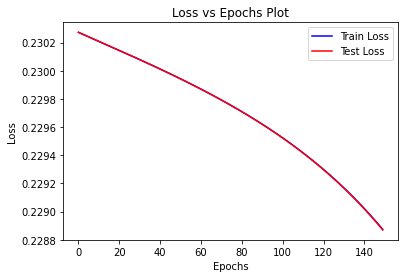

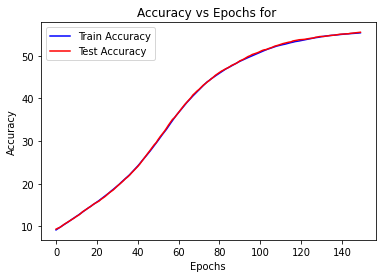

Test Accuracy: 55.50000000000001


In [25]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=2, 
                        Layer_sizes=[200, 50], activation="tanh", 
                        learning_rate=0.01, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp2LayerLr0.01tanh", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.23027861693035798, Score: 8.838333333333333
Epoch: 1, Loss: 0.23027797487514357, Score: 8.881666666666668
Epoch: 2, Loss: 0.23027733287550484, Score: 8.91
Epoch: 3, Loss: 0.23027669093068295, Score: 8.941666666666666
Epoch: 4, Loss: 0.23027604903992, Score: 8.985
Epoch: 5, Loss: 0.2302754072024577, Score: 9.02
Epoch: 6, Loss: 0.23027476541753833, Score: 9.053333333333333
Epoch: 7, Loss: 0.23027412368440395, Score: 9.1
Epoch: 8, Loss: 0.230273482002297, Score: 9.135
Epoch: 9, Loss: 0.23027284037046034, Score: 9.185
Epoch: 10, Loss: 0.23027219878813626, Score: 9.211666666666666
Epoch: 11, Loss: 0.23027155725456822, Score: 9.25
Epoch: 12, Loss: 0.23027091576899905, Score: 9.291666666666666
Epoch: 13, Loss: 0.23027027433067226, Score: 9.315
Epoch: 14, Loss: 0.23026963293883104, Score: 9.336666666666666
Epoch: 15, Loss: 0.23026899159271896, Score: 9.358333333333334
Epoch: 16, Loss: 0.23026835029157994, Score: 9.388333333333334
Epoch: 17, Loss: 0.23026770903465785, Score: 9

Epoch: 136, Loss: 0.2301914984228957, Score: 13.26
Epoch: 137, Loss: 0.2301908570129027, Score: 13.303333333333335
Epoch: 138, Loss: 0.23019021555625835, Score: 13.33
Epoch: 139, Loss: 0.23018957405221216, Score: 13.375
Epoch: 140, Loss: 0.23018893250001396, Score: 13.415
Epoch: 141, Loss: 0.23018829089891346, Score: 13.446666666666667
Epoch: 142, Loss: 0.23018764924816001, Score: 13.495
Epoch: 143, Loss: 0.23018700754700291, Score: 13.530000000000001
Epoch: 144, Loss: 0.2301863657946919, Score: 13.565
Epoch: 145, Loss: 0.2301857239904762, Score: 13.598333333333334
Epoch: 146, Loss: 0.23018508213360492, Score: 13.63
Epoch: 147, Loss: 0.2301844402233273, Score: 13.653333333333334
Epoch: 148, Loss: 0.23018379825889246, Score: 13.701666666666668
Epoch: 149, Loss: 0.23018315623954952, Score: 13.735


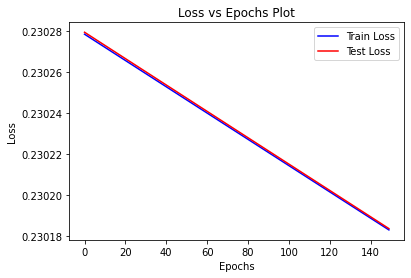

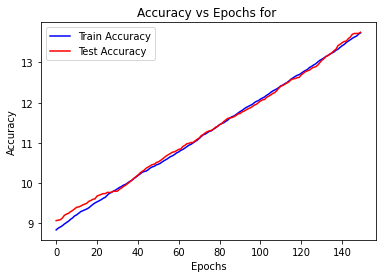

Test Accuracy: 13.750000000000002


In [26]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=2, 
                        Layer_sizes=[200, 50], activation="tanh", 
                        learning_rate=0.001, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp2LayerLr0.001tanh", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.2262507843084517, Score: 43.25
Epoch: 1, Loss: 0.22206353347690375, Score: 53.74666666666666
Epoch: 2, Loss: 0.21711047058196714, Score: 57.15
Epoch: 3, Loss: 0.2110068531422133, Score: 58.32666666666667
Epoch: 4, Loss: 0.20366106544708804, Score: 58.01833333333334
Epoch: 5, Loss: 0.1953191893291542, Score: 57.16833333333333
Epoch: 6, Loss: 0.1864929331862584, Score: 56.32833333333333
Epoch: 7, Loss: 0.17775743528950352, Score: 55.645
Epoch: 8, Loss: 0.16954799294178358, Score: 55.443333333333335
Epoch: 9, Loss: 0.16208066654706885, Score: 55.605000000000004
Epoch: 10, Loss: 0.15539102636933932, Score: 56.01166666666667
Epoch: 11, Loss: 0.14941181125764197, Score: 56.81
Epoch: 12, Loss: 0.1440364206082956, Score: 57.68833333333333
Epoch: 13, Loss: 0.13915688760239042, Score: 58.75333333333334
Epoch: 14, Loss: 0.1346816872553442, Score: 59.848333333333336
Epoch: 15, Loss: 0.1305407430384636, Score: 60.94500000000001
Epoch: 16, Loss: 0.12668361982964985, Score: 61.99833

Epoch: 138, Loss: 0.051470988034032716, Score: 82.08
Epoch: 139, Loss: 0.05136085193188194, Score: 82.12333333333333
Epoch: 140, Loss: 0.05125213278755111, Score: 82.16
Epoch: 141, Loss: 0.05114480682865403, Score: 82.19333333333333
Epoch: 142, Loss: 0.051038850646088554, Score: 82.22333333333334
Epoch: 143, Loss: 0.05093424118933864, Score: 82.26833333333333
Epoch: 144, Loss: 0.05083095576206784, Score: 82.30833333333332
Epoch: 145, Loss: 0.05072897201795822, Score: 82.34
Epoch: 146, Loss: 0.05062826795675381, Score: 82.38
Epoch: 147, Loss: 0.050528821920473345, Score: 82.43166666666667
Epoch: 148, Loss: 0.050430612589760324, Score: 82.46833333333333
Epoch: 149, Loss: 0.05033361898034305, Score: 82.505


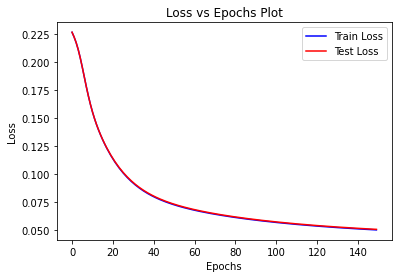

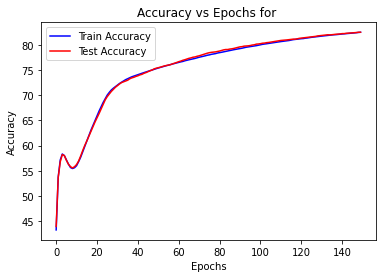

Test Accuracy: 82.50999999999999


In [27]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[100], activation="tanh", 
                        learning_rate=0.1, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp1LayerLr0.1tanh", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.2298992244715282, Score: 12.933333333333334
Epoch: 1, Loss: 0.2294886993573072, Score: 15.681666666666667
Epoch: 2, Loss: 0.22907947902083145, Score: 18.703333333333333
Epoch: 3, Loss: 0.22867071819885906, Score: 22.03333333333333
Epoch: 4, Loss: 0.22826159606531485, Score: 25.985000000000003
Epoch: 5, Loss: 0.22785131508195744, Score: 30.026666666666667
Epoch: 6, Loss: 0.2274391000509032, Score: 33.96
Epoch: 7, Loss: 0.22702419736381882, Score: 37.535000000000004
Epoch: 8, Loss: 0.22660587444291935, Score: 40.56
Epoch: 9, Loss: 0.22618341936902953, Score: 43.0
Epoch: 10, Loss: 0.22575614069188144, Score: 44.968333333333334
Epoch: 11, Loss: 0.2253233674175577, Score: 46.64
Epoch: 12, Loss: 0.22488444916752934, Score: 47.998333333333335
Epoch: 13, Loss: 0.2244387565031037, Score: 49.225
Epoch: 14, Loss: 0.22398568140829922, Score: 50.28666666666667
Epoch: 15, Loss: 0.22352463792319546, Score: 51.10333333333333
Epoch: 16, Loss: 0.2230550629187154, Score: 51.841666666666

Epoch: 136, Loss: 0.1390510815543517, Score: 59.01333333333333
Epoch: 137, Loss: 0.13858880303532256, Score: 59.099999999999994
Epoch: 138, Loss: 0.13813034150149603, Score: 59.20166666666666
Epoch: 139, Loss: 0.1376756278729611, Score: 59.326666666666675
Epoch: 140, Loss: 0.13722459504044113, Score: 59.416666666666664
Epoch: 141, Loss: 0.13677717784208807, Score: 59.51
Epoch: 142, Loss: 0.1363333130370852, Score: 59.593333333333334
Epoch: 143, Loss: 0.1358929392763877, Score: 59.696666666666665
Epoch: 144, Loss: 0.1354559970709024, Score: 59.81333333333333
Epoch: 145, Loss: 0.1350224287574008, Score: 59.92333333333333
Epoch: 146, Loss: 0.134592178462436, Score: 60.02166666666666
Epoch: 147, Loss: 0.1341651920645234, Score: 60.135000000000005
Epoch: 148, Loss: 0.1337414171548258, Score: 60.255
Epoch: 149, Loss: 0.1333208029965716, Score: 60.358333333333334


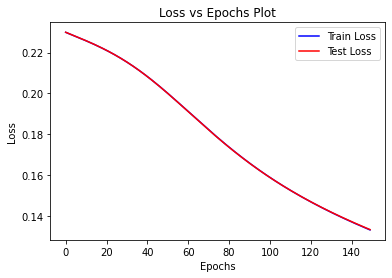

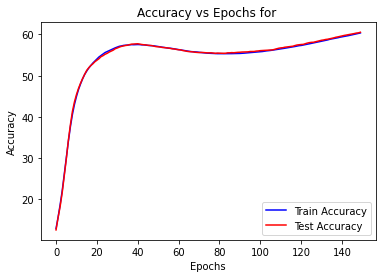

Test Accuracy: 60.529999999999994


In [28]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[100], activation="tanh", 
                        learning_rate=0.01, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp1LayerLr0.01tanh", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.23027059614164905, Score: 10.578333333333333
Epoch: 1, Loss: 0.23022929240418807, Score: 10.826666666666666
Epoch: 2, Loss: 0.23018801331607683, Score: 11.09
Epoch: 3, Loss: 0.2301467579876426, Score: 11.351666666666667
Epoch: 4, Loss: 0.23010552553186403, Score: 11.648333333333333
Epoch: 5, Loss: 0.23006431506435454, Score: 11.893333333333334
Epoch: 6, Loss: 0.2300231257033464, Score: 12.136666666666667
Epoch: 7, Loss: 0.2299819565696755, Score: 12.396666666666667
Epoch: 8, Loss: 0.2299408067867654, Score: 12.68
Epoch: 9, Loss: 0.22989967548061163, Score: 12.93
Epoch: 10, Loss: 0.22985856177976763, Score: 13.221666666666668
Epoch: 11, Loss: 0.22981746481532855, Score: 13.483333333333333
Epoch: 12, Loss: 0.22977638372091766, Score: 13.761666666666667
Epoch: 13, Loss: 0.22973531763267122, Score: 13.981666666666667
Epoch: 14, Loss: 0.229694265689225, Score: 14.256666666666668
Epoch: 15, Loss: 0.2296532270316987, Score: 14.543333333333333
Epoch: 16, Loss: 0.2296122008036

Epoch: 137, Loss: 0.2245015288709705, Score: 48.95166666666667
Epoch: 138, Loss: 0.22445627442192898, Score: 49.108333333333334
Epoch: 139, Loss: 0.2244109434919602, Score: 49.218333333333334
Epoch: 140, Loss: 0.22436553548729082, Score: 49.336666666666666
Epoch: 141, Loss: 0.22432004981638456, Score: 49.45666666666666
Epoch: 142, Loss: 0.22427448588995075, Score: 49.565
Epoch: 143, Loss: 0.2242288431209534, Score: 49.678333333333335
Epoch: 144, Loss: 0.22418312092462037, Score: 49.766666666666666
Epoch: 145, Loss: 0.22413731871845177, Score: 49.885000000000005
Epoch: 146, Loss: 0.2240914359222299, Score: 49.99666666666667
Epoch: 147, Loss: 0.22404547195802815, Score: 50.08833333333334
Epoch: 148, Loss: 0.22399942625022085, Score: 50.19166666666667
Epoch: 149, Loss: 0.2239532982254923, Score: 50.288333333333334


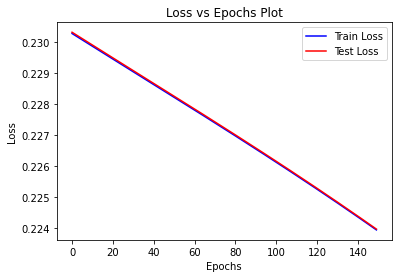

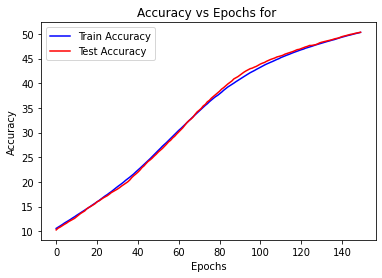

Test Accuracy: 50.32


In [29]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[100], activation="tanh", 
                        learning_rate=0.001, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp1LayerLr0.001tanh", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.22099596651862496, Score: 48.02666666666667
Epoch: 1, Loss: 0.21082098559658624, Score: 57.54833333333333
Epoch: 2, Loss: 0.19977870204365994, Score: 61.21
Epoch: 3, Loss: 0.1877881729070747, Score: 62.44166666666666
Epoch: 4, Loss: 0.1755783600208355, Score: 62.873333333333335
Epoch: 5, Loss: 0.16411678706639973, Score: 63.001666666666665
Epoch: 6, Loss: 0.1540113088363318, Score: 63.08166666666667
Epoch: 7, Loss: 0.14536753919743256, Score: 63.29666666666667
Epoch: 8, Loss: 0.13800093616467354, Score: 63.695
Epoch: 9, Loss: 0.1316519021967268, Score: 64.40333333333334
Epoch: 10, Loss: 0.12609008174122172, Score: 65.24333333333333
Epoch: 11, Loss: 0.12114260392381482, Score: 66.14333333333333
Epoch: 12, Loss: 0.11668878505928898, Score: 67.12333333333333
Epoch: 13, Loss: 0.11264580673183952, Score: 67.95
Epoch: 14, Loss: 0.10895579948720124, Score: 68.67166666666667
Epoch: 15, Loss: 0.10557672545671522, Score: 69.3
Epoch: 16, Loss: 0.10247645650415191, Score: 69.895


Epoch: 137, Loss: 0.04959079602856074, Score: 82.60833333333333
Epoch: 138, Loss: 0.04950802478219675, Score: 82.64166666666667
Epoch: 139, Loss: 0.04942628474214835, Score: 82.68666666666667
Epoch: 140, Loss: 0.049345556202424104, Score: 82.715
Epoch: 141, Loss: 0.049265819904319934, Score: 82.73833333333333
Epoch: 142, Loss: 0.04918705702431647, Score: 82.78
Epoch: 143, Loss: 0.04910924916239003, Score: 82.79666666666667
Epoch: 144, Loss: 0.04903237833072155, Score: 82.82666666666667
Epoch: 145, Loss: 0.048956426942788636, Score: 82.86
Epoch: 146, Loss: 0.04888137780282561, Score: 82.87833333333333
Epoch: 147, Loss: 0.048807214095637645, Score: 82.895
Epoch: 148, Loss: 0.04873391937675522, Score: 82.92500000000001
Epoch: 149, Loss: 0.04866147756291483, Score: 82.95333333333333


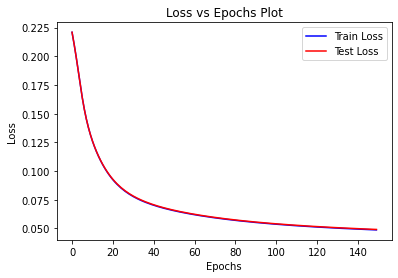

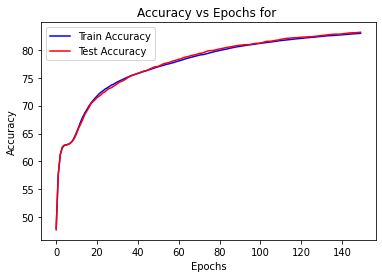

Test Accuracy: 83.15


In [37]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[256], activation="tanh", 
                        learning_rate=0.1, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp1Layer256Lr0.1tanh", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.23040576266841803, Score: 12.823333333333334
Epoch: 1, Loss: 0.22933787559756244, Score: 20.496666666666666
Epoch: 2, Loss: 0.22827902416926657, Score: 27.328333333333333
Epoch: 3, Loss: 0.2272270643414736, Score: 32.70166666666667
Epoch: 4, Loss: 0.226179985247003, Score: 36.873333333333335
Epoch: 5, Loss: 0.22513590389862778, Score: 40.11666666666667
Epoch: 6, Loss: 0.22409306095828782, Score: 42.656666666666666
Epoch: 7, Loss: 0.2230498174488657, Score: 44.64666666666667
Epoch: 8, Loss: 0.22200465229321956, Score: 46.42
Epoch: 9, Loss: 0.22095616056954076, Score: 47.928333333333335
Epoch: 10, Loss: 0.21990305237493474, Score: 49.18666666666667
Epoch: 11, Loss: 0.21884415219075096, Score: 50.43666666666666
Epoch: 12, Loss: 0.2177783986439663, Score: 51.61666666666667
Epoch: 13, Loss: 0.2167048445591878, Score: 52.63833333333333
Epoch: 14, Loss: 0.21562265719593937, Score: 53.635
Epoch: 15, Loss: 0.21453111856617332, Score: 54.47
Epoch: 16, Loss: 0.21342962572772814,

Epoch: 137, Loss: 0.11284897757385653, Score: 68.12833333333333
Epoch: 138, Loss: 0.11246264352223442, Score: 68.19
Epoch: 139, Loss: 0.11207986329339806, Score: 68.23666666666666
Epoch: 140, Loss: 0.1117005900195492, Score: 68.33
Epoch: 141, Loss: 0.11132477812979234, Score: 68.39166666666667
Epoch: 142, Loss: 0.11095238329443821, Score: 68.47999999999999
Epoch: 143, Loss: 0.11058336237162592, Score: 68.53666666666666
Epoch: 144, Loss: 0.11021767335618426, Score: 68.605
Epoch: 145, Loss: 0.10985527533065033, Score: 68.685
Epoch: 146, Loss: 0.10949612841836764, Score: 68.76
Epoch: 147, Loss: 0.10914019373858735, Score: 68.83666666666667
Epoch: 148, Loss: 0.10878743336349689, Score: 68.89
Epoch: 149, Loss: 0.10843781027710388, Score: 68.96


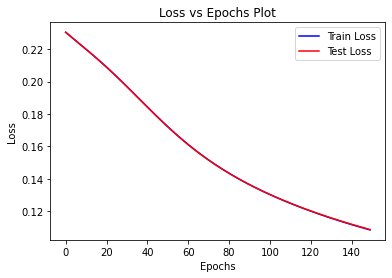

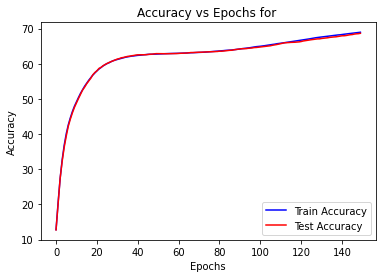

Test Accuracy: 68.66


In [38]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[256], activation="tanh", 
                        learning_rate=0.01, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp1Layer256Lr0.01tanh", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

Epoch: 0, Loss: 0.2313767662793974, Score: 6.9783333333333335
Epoch: 1, Loss: 0.23126868664768369, Score: 7.498333333333333
Epoch: 2, Loss: 0.2311607277919826, Score: 8.053333333333333
Epoch: 3, Loss: 0.23105288732609056, Score: 8.605
Epoch: 4, Loss: 0.23094516287833472, Score: 9.25
Epoch: 5, Loss: 0.23083755209149212, Score: 9.908333333333333
Epoch: 6, Loss: 0.23073005262270857, Score: 10.621666666666666
Epoch: 7, Loss: 0.23062266214342114, Score: 11.368333333333332
Epoch: 8, Loss: 0.23051537833927932, Score: 12.058333333333334
Epoch: 9, Loss: 0.23040819891006997, Score: 12.796666666666667
Epoch: 10, Loss: 0.2303011215696429, Score: 13.526666666666667
Epoch: 11, Loss: 0.23019414404583663, Score: 14.318333333333333
Epoch: 12, Loss: 0.23008726408040742, Score: 15.104999999999999
Epoch: 13, Loss: 0.22998047942895822, Score: 15.873333333333333
Epoch: 14, Loss: 0.22987378786086998, Score: 16.634999999999998
Epoch: 15, Loss: 0.2297671871592328, Score: 17.405
Epoch: 16, Loss: 0.2296606751207

Epoch: 138, Loss: 0.21676961552525176, Score: 52.515
Epoch: 139, Loss: 0.2166611370249323, Score: 52.626666666666665
Epoch: 140, Loss: 0.21655256817189916, Score: 52.733333333333334
Epoch: 141, Loss: 0.21644390824679974, Score: 52.855
Epoch: 142, Loss: 0.21633515654186317, Score: 52.949999999999996
Epoch: 143, Loss: 0.21622631236090498, Score: 53.031666666666666
Epoch: 144, Loss: 0.21611737501933215, Score: 53.12
Epoch: 145, Loss: 0.21600834384414636, Score: 53.21
Epoch: 146, Loss: 0.21589921817394833, Score: 53.303333333333335
Epoch: 147, Loss: 0.21578999735894197, Score: 53.41833333333334
Epoch: 148, Loss: 0.2156806807609378, Score: 53.52166666666667
Epoch: 149, Loss: 0.21557126775335647, Score: 53.63


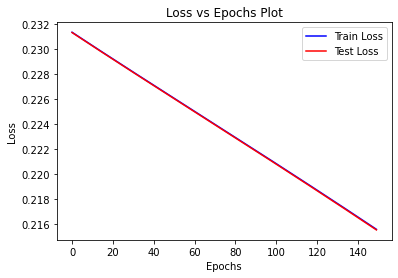

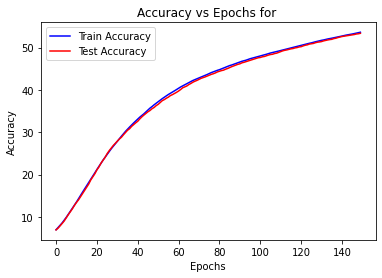

Test Accuracy: 53.38


In [39]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[256], activation="tanh", 
                        learning_rate=0.001, weight_init="random", 
                        num_epochs=150, batch_size=len(trainX), 
                        backpropogation='gd', modelName="./Models/mlp1Layer256Lr0.001tanh", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

## MLP with Different Optimizers

### Gradient Descent with Momentum

Epoch: 0, Loss: 0.1656619163856681, Score: 60.11
Epoch: 1, Loss: 0.1078600364041147, Score: 67.17166666666667
Epoch: 2, Loss: 0.08658409352113285, Score: 71.76
Epoch: 3, Loss: 0.0753021472977851, Score: 74.04166666666666
Epoch: 4, Loss: 0.06867403662535591, Score: 75.42166666666667
Epoch: 5, Loss: 0.06432627813793264, Score: 76.45166666666667
Epoch: 6, Loss: 0.06109398461692724, Score: 77.57166666666667
Epoch: 7, Loss: 0.058499204127812454, Score: 78.51666666666667
Epoch: 8, Loss: 0.05633273221473142, Score: 79.38499999999999
Epoch: 9, Loss: 0.05448908650245473, Score: 80.19
Epoch: 10, Loss: 0.05290515504908606, Score: 80.84833333333333
Epoch: 11, Loss: 0.051536163996995725, Score: 81.50166666666667
Epoch: 12, Loss: 0.050343451335480516, Score: 82.06333333333333
Epoch: 13, Loss: 0.04929692757664438, Score: 82.49499999999999
Epoch: 14, Loss: 0.048370019184212916, Score: 82.87
Epoch: 15, Loss: 0.04754280258445545, Score: 83.17333333333333
Epoch: 16, Loss: 0.046797260335764375, Score: 83.

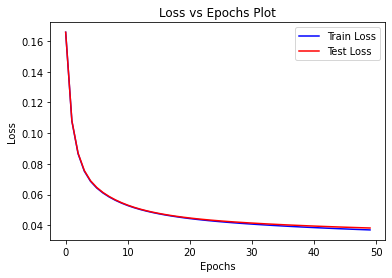

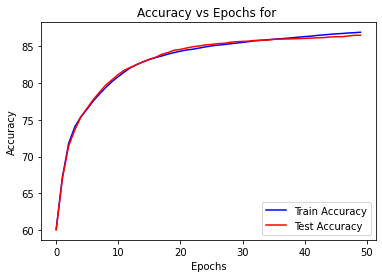

Test Accuracy: 86.47


In [41]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[256], activation="relu", 
                        learning_rate=0.0001, weight_init="random", 
                        num_epochs=50, batch_size=64, 
                        backpropogation='momentum', modelName="./Models/mlp1Layer256Lr0.1reluMomentum", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

### Nesterov's Accelerated Gradient


Epoch: 0, Loss: 0.16548267822511095, Score: 60.095
Epoch: 1, Loss: 0.10780624766323994, Score: 67.19000000000001
Epoch: 2, Loss: 0.08655675426582861, Score: 71.765
Epoch: 3, Loss: 0.07528632328041779, Score: 74.045
Epoch: 4, Loss: 0.06866444633899321, Score: 75.42333333333333
Epoch: 5, Loss: 0.06431940141499864, Score: 76.45666666666666
Epoch: 6, Loss: 0.06108829854930178, Score: 77.57
Epoch: 7, Loss: 0.058494172363125, Score: 78.515
Epoch: 8, Loss: 0.056328325678923465, Score: 79.38833333333334
Epoch: 9, Loss: 0.054485012748257115, Score: 80.19833333333334
Epoch: 10, Loss: 0.052901559092266966, Score: 80.84333333333333
Epoch: 11, Loss: 0.05153286524949841, Score: 81.50166666666667
Epoch: 12, Loss: 0.05034048147789264, Score: 82.065
Epoch: 13, Loss: 0.04929403291253244, Score: 82.49333333333333
Epoch: 14, Loss: 0.048367506209600945, Score: 82.86833333333334
Epoch: 15, Loss: 0.04754050648302773, Score: 83.165
Epoch: 16, Loss: 0.04679505065554769, Score: 83.43666666666667
Epoch: 17, Loss

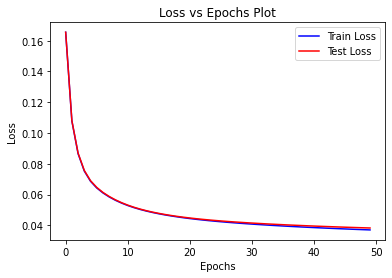

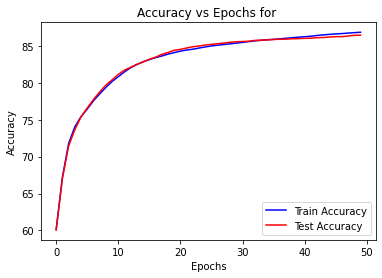

Test Accuracy: 86.48


In [42]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[256], activation="relu", 
                        learning_rate=0.0001, weight_init="random", 
                        num_epochs=50, batch_size=64, 
                        backpropogation='nag', modelName="./Models/mlp1Layer256Lr0.1reluNag", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

### Adagrad

Epoch: 0, Loss: 0.057527802408104775, Score: 80.09333333333333
Epoch: 1, Loss: 0.05213226535800121, Score: 82.03166666666667
Epoch: 2, Loss: 0.049370671262108326, Score: 82.96333333333334
Epoch: 3, Loss: 0.04752161378650717, Score: 83.59333333333333
Epoch: 4, Loss: 0.04618557225712194, Score: 83.99666666666667
Epoch: 5, Loss: 0.04513158840790731, Score: 84.37833333333333
Epoch: 6, Loss: 0.044276846218053716, Score: 84.69166666666666
Epoch: 7, Loss: 0.04355493635245007, Score: 84.96166666666667
Epoch: 8, Loss: 0.042933355330561196, Score: 85.15166666666667
Epoch: 9, Loss: 0.04238243506505592, Score: 85.40333333333334
Epoch: 10, Loss: 0.04189378251792402, Score: 85.54666666666667
Epoch: 11, Loss: 0.04145499305750471, Score: 85.68
Epoch: 12, Loss: 0.04105632307231348, Score: 85.84666666666666
Epoch: 13, Loss: 0.04069134121563942, Score: 85.95
Epoch: 14, Loss: 0.040352257419010405, Score: 86.07666666666667
Epoch: 15, Loss: 0.04003448654487198, Score: 86.175
Epoch: 16, Loss: 0.0397388925040

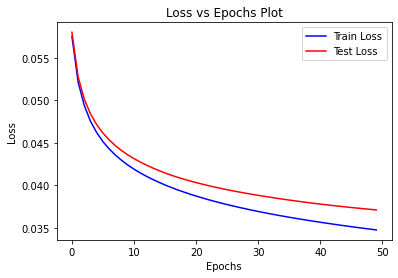

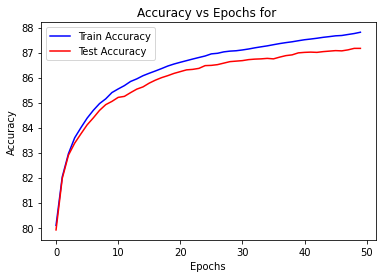

Test Accuracy: 87.17


In [57]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[256], activation="relu", 
                        learning_rate=0.0001, weight_init="random", 
                        num_epochs=50, batch_size=64, 
                        backpropogation='adagrad', modelName="./Models/mlp1Layer256Lr0.1reluAdagrad", 
                        loadModel=False, saveModel=False)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

### RMSProp

Epoch: 0, Loss: 0.04603141920373668, Score: 83.81666666666666
Epoch: 1, Loss: 0.03960867553695338, Score: 85.91166666666666
Epoch: 2, Loss: 0.036474759697717275, Score: 87.05833333333334
Epoch: 3, Loss: 0.03427586506027297, Score: 87.83833333333332
Epoch: 4, Loss: 0.0325613979340542, Score: 88.425
Epoch: 5, Loss: 0.031129518826410126, Score: 88.94666666666666
Epoch: 6, Loss: 0.029896000083177103, Score: 89.32
Epoch: 7, Loss: 0.02878713714983115, Score: 89.70833333333333
Epoch: 8, Loss: 0.027796372778814613, Score: 90.06666666666666
Epoch: 9, Loss: 0.026887166121649392, Score: 90.36833333333333
Epoch: 10, Loss: 0.026064803666196592, Score: 90.69500000000001
Epoch: 11, Loss: 0.025296663366549937, Score: 90.985
Epoch: 12, Loss: 0.02457026166492893, Score: 91.25666666666666
Epoch: 13, Loss: 0.023882823418139822, Score: 91.53
Epoch: 14, Loss: 0.02323961393999315, Score: 91.78666666666668
Epoch: 15, Loss: 0.022613456747376172, Score: 92.00666666666667
Epoch: 16, Loss: 0.02203169011838194, Sc

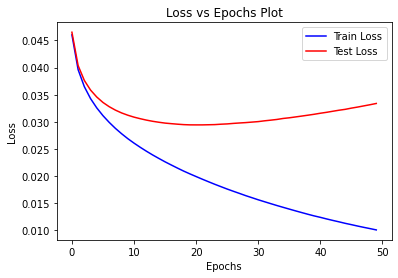

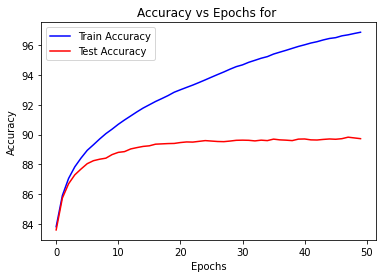

Test Accuracy: 89.73


In [46]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[256], activation="relu", 
                        learning_rate=0.0001, weight_init="random", 
                        num_epochs=50, batch_size=64, 
                        backpropogation='rmsprop', modelName="./Models/mlp1Layer256Lr0.1reluRMSProp", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))

### Adam

Epoch: 0, Loss: 0.051009865607722436, Score: 81.92666666666668
Epoch: 1, Loss: 0.04633151194673995, Score: 83.75166666666667
Epoch: 2, Loss: 0.044014046664911925, Score: 84.41333333333333
Epoch: 3, Loss: 0.04247752580474475, Score: 84.925
Epoch: 4, Loss: 0.0413220919190636, Score: 85.36
Epoch: 5, Loss: 0.0403872968801462, Score: 85.72166666666666
Epoch: 6, Loss: 0.03959718386490515, Score: 85.98833333333333
Epoch: 7, Loss: 0.038907015207100104, Score: 86.24000000000001
Epoch: 8, Loss: 0.03829226760944427, Score: 86.405
Epoch: 9, Loss: 0.03773487302387185, Score: 86.62166666666667
Epoch: 10, Loss: 0.03722290922222873, Score: 86.81333333333333
Epoch: 11, Loss: 0.03674697347777146, Score: 86.98666666666666
Epoch: 12, Loss: 0.0363012007153774, Score: 87.14
Epoch: 13, Loss: 0.035881271612508196, Score: 87.275
Epoch: 14, Loss: 0.03548233500428827, Score: 87.425
Epoch: 15, Loss: 0.03510157119113142, Score: 87.53333333333333
Epoch: 16, Loss: 0.03473704584585501, Score: 87.66666666666667
Epoch:

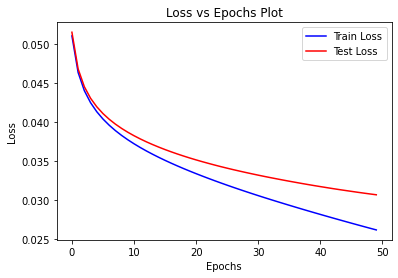

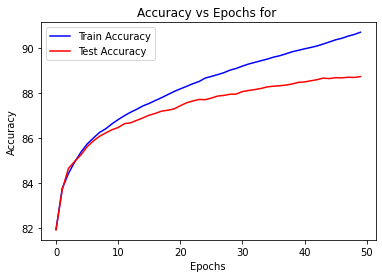

Test Accuracy: 88.73


In [47]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, 
                        Layer_sizes=[256], activation="relu", 
                        learning_rate=0.0001, weight_init="random", 
                        num_epochs=50, batch_size=64, 
                        backpropogation='adam', modelName="./Models/mlp1Layer256Lr0.1reluAdam", 
                        loadModel=False, saveModel=True)
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)
lossVsEpochPlot(trainLoss, testLoss)
accVsEpochPlot(trainAccs, testAccs)
print("Test Accuracy: " + str(model.score(testX, testY)))